# Sentiment analyzers

Consider a Python example that compares different sentiment analyzers on the same **ambigous** sentence to show how they can produce varying results. 

The script includes:

1. **NLTK VADER**: A rule-based sentiment analyzer that's specifically attuned to social media text and handles negations.
2. **TextBlob**: A simple API that provides polarity (positive/negative) and subjectivity scores.
3. **spaCy with spacytextblob**: An extension that brings TextBlob's functionality into spaCy's pipeline.
4. **BERT**: A transformer-based model that provides more contextual understanding of the text.
5. **Flair**: A powerful NLP library with state-of-the-art sentiment models.
6. **RoBERTa**: Another transformer model with different architecture than BERT.


To run this code, you'll need to install the required packages:

In [91]:
#!pip install nltk textblob spacy transformers pandas matplotlib scikit-learn torch spacytextblob flair

#!python -m spacy download en_core_web_sm
#!python -m textblob.download_corpora

#!pip install spacytextblob
#!pip install flair

In [1]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [27]:
# Download necessary NLTK data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Vitali\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Example ambiguous sentence with mixed sentiment
sentence = "The movie was not bad, but I've seen better ones."

print(f"Analyzing sentiment for: '{sentence}'")

Analyzing sentiment for: 'The movie was not bad, but I've seen better ones.'


In [5]:
results = {}

In [7]:
# 1. NLTK VADER
vader = SentimentIntensityAnalyzer()
vader_scores = vader.polarity_scores(sentence)
results["VADER"] = {
    "Positive": vader_scores["pos"],
    "Negative": vader_scores["neg"],
    "Neutral": vader_scores["neu"],
    "Compound": vader_scores["compound"],
    "Interpretation": "Positive" if vader_scores["compound"] >= 0.05 else 
                      "Negative" if vader_scores["compound"] <= -0.05 else "Neutral"
}

In [9]:
print(results["VADER"])

{'Positive': 0.419, 'Negative': 0.0, 'Neutral': 0.581, 'Compound': 0.698, 'Interpretation': 'Positive'}


In [11]:
# 2. TextBlob
blob = TextBlob(sentence)
textblob_polarity = blob.sentiment.polarity
textblob_subjectivity = blob.sentiment.subjectivity
results["TextBlob"] = {
    "Polarity": textblob_polarity,
    "Subjectivity": textblob_subjectivity,
    "Interpretation": "Positive" if textblob_polarity > 0 else 
                      "Negative" if textblob_polarity < 0 else "Neutral"
}

In [13]:
print(results["TextBlob"])

{'Polarity': 0.42499999999999993, 'Subjectivity': 0.5833333333333333, 'Interpretation': 'Positive'}


In [15]:
# 3. spaCy (with spacytextblob)
# Note: You need to install: !pip install spacytextblob
try:
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe("spacytextblob")
    doc = nlp(sentence)
    spacy_polarity = doc._.blob.polarity
    spacy_subjectivity = doc._.blob.subjectivity
    results["spaCy (spacytextblob)"] = {
        "Polarity": spacy_polarity,
        "Subjectivity": spacy_subjectivity,
        "Interpretation": "Positive" if spacy_polarity > 0 else 
                          "Negative" if spacy_polarity < 0 else "Neutral"
    }
except:
    print("spaCy with spacytextblob not available. Install with: pip install spacytextblob")

C:\Users\Vitali\anaconda3\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [17]:
print(results["spaCy (spacytextblob)"])

{'Polarity': 0.42499999999999993, 'Subjectivity': 0.5833333333333333, 'Interpretation': 'Positive'}


In [19]:
# 4. BERT (using Hugging Face transformers)
try:
    tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
    model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
    classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    bert_result = classifier(sentence)[0]
    
    # This specific model returns 1-5 stars, mapping to very negative to very positive
    star_rating = int(bert_result['label'].split()[0])
    sentiment_mapping = {1: "Very Negative", 2: "Negative", 3: "Neutral", 4: "Positive", 5: "Very Positive"}
    
    results["BERT"] = {
        "Score": bert_result['score'],
        "Star Rating": star_rating,
        "Interpretation": sentiment_mapping[star_rating]
    }
except:
    print("BERT model not available. Install with: !pip install transformers torch")

Device set to use cpu


In [20]:
print(results["BERT"])

{'Score': 0.7099750638008118, 'Star Rating': 3, 'Interpretation': 'Neutral'}


In [23]:
# 5. Flair (if available)
try:
    from flair.models import TextClassifier
    from flair.data import Sentence
    
    flair_sentiment = TextClassifier.load('en-sentiment')
    flair_sentence = Sentence(sentence)
    flair_sentiment.predict(flair_sentence)
    
    label = flair_sentence.labels[0]
    results["Flair"] = {
        "Score": label.score,
        "Label": label.value,
        "Interpretation": "Positive" if label.value == "POSITIVE" else "Negative"
    }
except:
    print("Flair not available. Install with: !pip install flair")

In [25]:
print(results["Flair"])

{'Score': 0.9997748732566833, 'Label': 'NEGATIVE', 'Interpretation': 'Negative'}


In [39]:
# 6. RoBERTa (another transformer model with different architecture)
try:
    roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
    roberta_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
    roberta_classifier = pipeline("sentiment-analysis", model=roberta_model, tokenizer=roberta_tokenizer)
    roberta_result = roberta_classifier(sentence)[0]
    
    # Map the RoBERTa labels to human-readable format
    # For cardiffnlp/twitter-roberta-base-sentiment:
    # LABEL_0 = Negative
    # LABEL_1 = Neutral
    # LABEL_2 = Positive
    label_mapping = {
        "LABEL_0": "Negative",
        "LABEL_1": "Neutral", 
        "LABEL_2": "Positive"
    }
    
    human_readable_label = label_mapping.get(roberta_result['label'], "Unknown")
    
    results["RoBERTa"] = {
        "Score": roberta_result['score'],
        "Raw Label": roberta_result['label'],
        "Interpretation": human_readable_label
    }
except:
    print("RoBERTa model not available.")

In [41]:
print(results["RoBERTa"])

{'Score': 0.7613462805747986, 'Raw Label': 'LABEL_2', 'Interpretation': 'Positive'}



Results Comparison:

VADER:
  Positive: 0.419
  Negative: 0.0
  Neutral: 0.581
  Compound: 0.698
  Interpretation: Positive

TextBlob:
  Polarity: 0.42499999999999993
  Subjectivity: 0.5833333333333333
  Interpretation: Positive

spaCy (spacytextblob):
  Polarity: 0.42499999999999993
  Subjectivity: 0.5833333333333333
  Interpretation: Positive

BERT:
  Score: 0.7099750638008118
  Star Rating: 3
  Interpretation: Neutral

Flair:
  Score: 0.9997748732566833
  Label: NEGATIVE
  Interpretation: Negative

RoBERTa:
  Score: 0.7613462805747986
  Raw Label: LABEL_2
  Interpretation: Positive

Text-based Sentiment Visualization:
Sentiment Analysis Comparison for: "The movie was not bad, but I've seen better ones."
--------------------------------------------------------------------------------
VADER                 |             + (Positive)
TextBlob              |             + (Positive)
spaCy (spacytextblob) |             + (Positive)
BERT                  |         o (Neutral)
Flair      

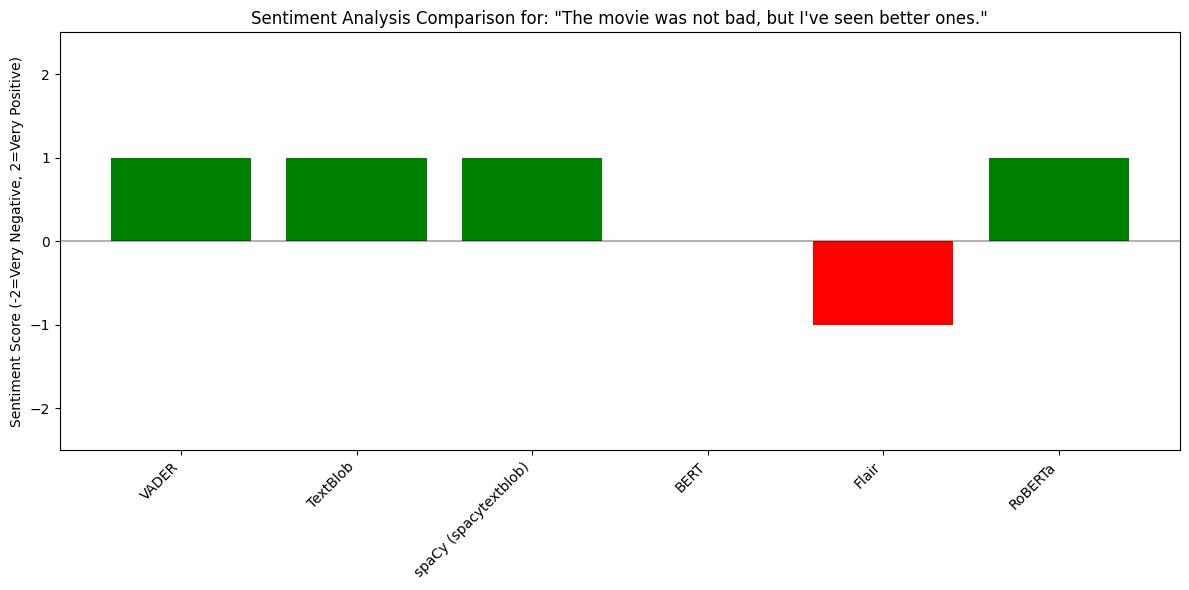

In [43]:
# Display results
print("\nResults Comparison:")
print("=" * 80)
for analyzer, result in results.items():
    print(f"\n{analyzer}:")
    for key, value in result.items():
        print(f"  {key}: {value}")

# Create a text-based visualization instead of matplotlib
print("\nText-based Sentiment Visualization:")
print("=" * 80)
print(f"Sentiment Analysis Comparison for: \"{sentence}\"")
print("-" * 80)

# Get the analyzers and their interpretations
analyzers = list(results.keys())
interpretations = [results[analyzer].get("Interpretation", "Unknown") for analyzer in analyzers]

# Map interpretations to numeric values and symbols
sentiment_map = {
    "Very Negative": -2, "Negative": -1, "Neutral": 0, 
    "Positive": 1, "Very Positive": 2
}

# Convert to numeric values (or default to 0 if not found)
numeric_sentiments = []
for interp in interpretations:
    # Handle different naming conventions
    if interp in sentiment_map:
        numeric_sentiments.append(sentiment_map[interp])
    elif "negative" in interp.lower() and "very" in interp.lower():
        numeric_sentiments.append(-2)
    elif "negative" in interp.lower():
        numeric_sentiments.append(-1)
    elif "positive" in interp.lower() and "very" in interp.lower():
        numeric_sentiments.append(2)
    elif "positive" in interp.lower():
        numeric_sentiments.append(1)
    elif "neutral" in interp.lower():
        numeric_sentiments.append(0)
    else:
        numeric_sentiments.append(0)

# Define symbols for visualization
symbols = {-2: "-- (Very Negative)", -1: "- (Negative)", 0: "o (Neutral)", 
           1: "+ (Positive)", 2: "++ (Very Positive)"}

# Display the text-based visualization
max_analyzer_length = max(len(analyzer) for analyzer in analyzers)
for analyzer, score in zip(analyzers, numeric_sentiments):
    # Create a visual representation with padding
    scale = "    " * (score + 2) + symbols[score]
    print(f"{analyzer:{max_analyzer_length}} | {scale}")

print("\nResults Summary:")
print(f"Sentence: '{sentence}'")
print(f"Number of analyzers compared: {len(results)}")
print(f"Analyzers that found positive sentiment: {sum(1 for s in numeric_sentiments if s > 0)}")
print(f"Analyzers that found negative sentiment: {sum(1 for s in numeric_sentiments if s < 0)}")
print(f"Analyzers that found neutral sentiment: {sum(1 for s in numeric_sentiments if s == 0)}")

# Optional: Try to create visualization using matplotlib but handle errors gracefully
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    colors = ['red' if x < 0 else 'green' if x > 0 else 'gray' for x in numeric_sentiments]
    plt.bar(analyzers, numeric_sentiments, color=colors)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.ylim(-2.5, 2.5)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Sentiment Analysis Comparison for: "{sentence}"')
    plt.ylabel('Sentiment Score (-2=Very Negative, 2=Very Positive)')
    plt.tight_layout()
    plt.savefig('sentiment_comparison.png')
    print("\nVisualization saved as 'sentiment_comparison.png'")
except ImportError as e:
    print(f"\nMatplotlib visualization skipped due to import error: {e}")
    print("Using text-based visualization instead.")
except Exception as e:
    print(f"\nVisualization error: {e}")
    print("Using text-based visualization instead.")